In [1]:
# SECTION 1: SETUP AND DATA LOADING

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
import re
import string
import sys
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from wordcloud import WordCloud

# Download NLTK stopwords
nltk.download('stopwords', quiet=True)

# Add the path to the configuration file
sys.path.append(os.path.abspath(os.path.join('..')))
from config import PROCESSED_DATA_DIR, TEXT_COLUMN, PERSON_COUPLE_COLUMN, DATASET, RANDOM_STATE

In [ ]:
# --- Function to Load and Process Data ---
def load_and_process_json(file_path):
    """
    Loads a JSON file and processes nested dialogues into a single text column.
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    for entry in data:
        entry[TEXT_COLUMN] = " ".join([turn['text'] for turn in entry['dialogue']])
    return pd.DataFrame(data)

# --- Loading the Full Dataset ---
print(f"Loading the full dataset from: {PROCESSED_DATA_DIR}")
try:
    file_path = os.path.join(PROCESSED_DATA_DIR, DATASET)
    df_dataset = load_and_process_json(file_path)
    print(f"The full dataset has {df_dataset.shape[0]} samples.")
except FileNotFoundError as e:
    print(f"ERROR: JSON file not found: {e}. Make sure the file is in the correct location.")
    df_dataset = pd.DataFrame()

Loading the full dataset from: c:\Users\Andrei\Desktop\universita\1-A-2-S\NLP\Progetto\CIPV_project\data\processed
The full dataset has 1000 samples.


C:\Users\Andrei\AppData\Local\Temp\ipykernel_26840\1641565846.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=PERSON_COUPLE_COLUMN, data=df_dataset, order=df_dataset[PERSON_COUPLE_COLUMN].value_counts().index, palette='magma')


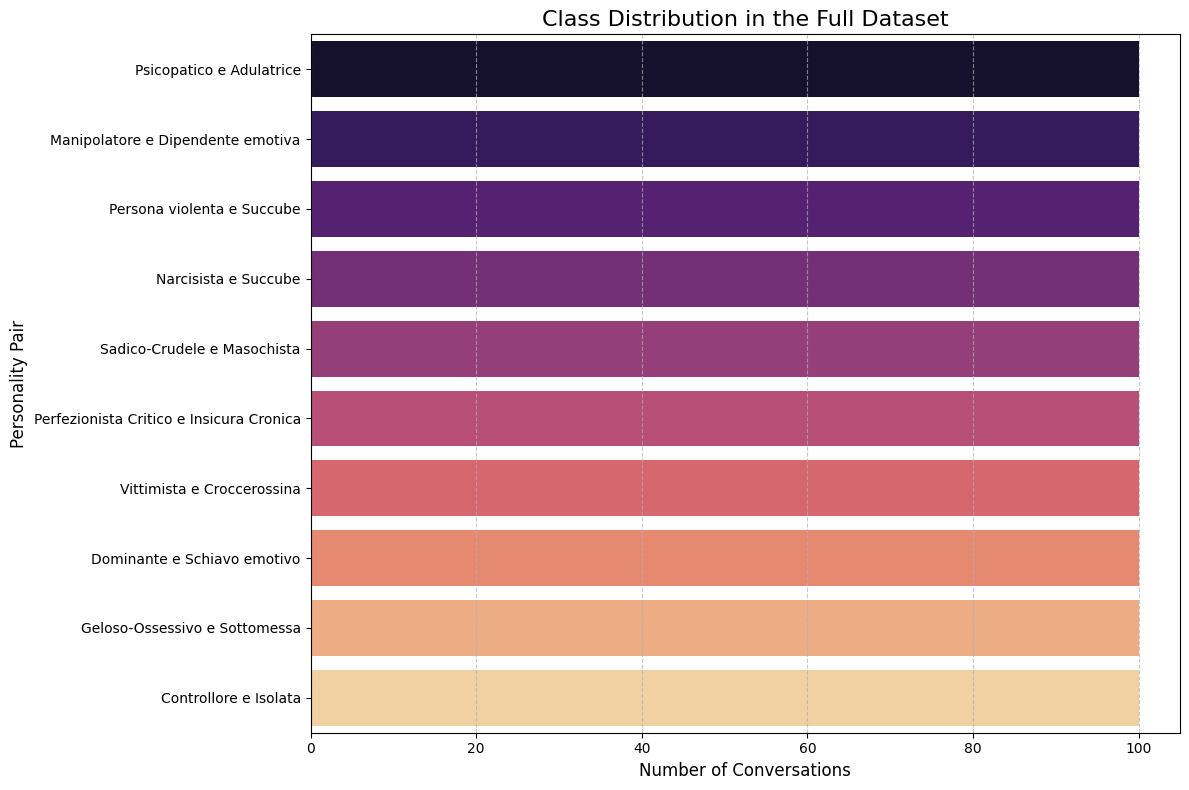


--- Summary Table: Class Distribution ---

                           Personality Pair  Number of Conversations
0                  Psicopatico e Adulatrice                      100
1         Manipolatore e Dipendente emotiva                      100
2                Persona violenta e Succube                      100
3                      Narcisista e Succube                      100
4               Sadico-Crudele e Masochista                      100
5  Perfezionista Critico e Insicura Cronica                      100
6                Vittimista e Croccerossina                      100
7               Dominante e Schiavo emotivo                      100
8             Geloso-Ossessivo e Sottomessa                      100
9                     Controllore e Isolata                      100
----------------------------------------


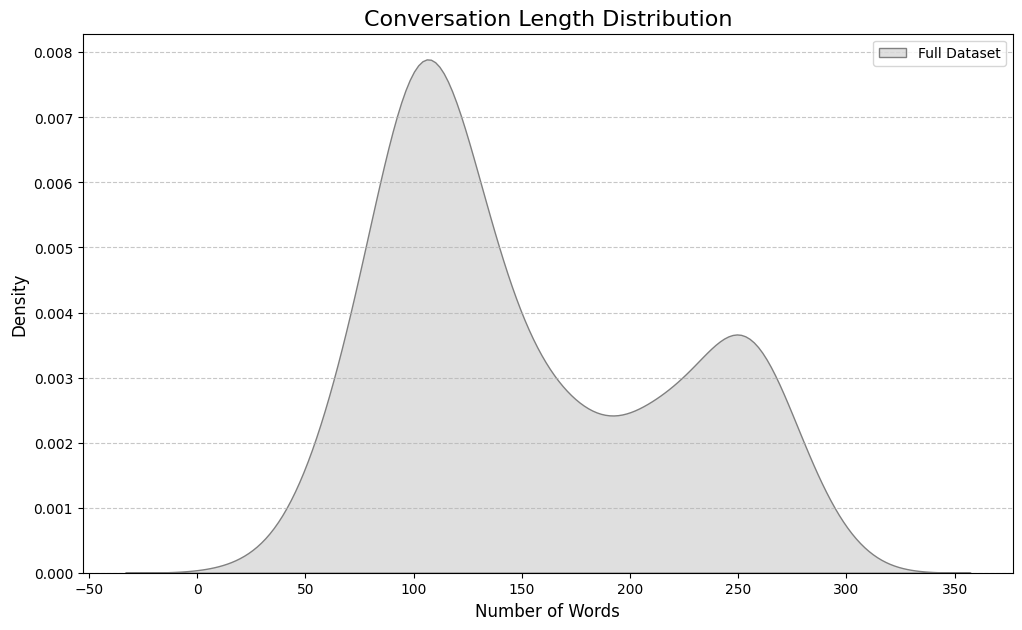


--- Summary Table: Conversation Length Statistics ---

count    1000.000000
mean      152.559000
std        66.761228
min        17.000000
25%       100.000000
50%       130.000000
75%       212.000000
max       307.000000
Name: conversation_length, dtype: float64
--------------------------------------------------


In [10]:
# SECTION 2: DATASET ANALYSIS

if not df_dataset.empty:
    # --- 2.1 Class Distribution ---
    plt.figure(figsize=(12, 8))
    sns.countplot(y=PERSON_COUPLE_COLUMN, data=df_dataset, order=df_dataset[PERSON_COUPLE_COLUMN].value_counts().index, palette='magma')
    plt.title('Class Distribution in the Full Dataset', fontsize=16)
    plt.xlabel('Number of Conversations', fontsize=12)
    plt.ylabel('Personality Pair', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # SUMMARY TABLE for Class Distribution
    print("\n--- Summary Table: Class Distribution ---\n")
    class_counts = df_dataset[PERSON_COUPLE_COLUMN].value_counts().reset_index()
    class_counts.columns = ['Personality Pair', 'Number of Conversations']
    print(class_counts)
    print("-" * 40)

    # --- 2.2 Conversation Length ---
    df_dataset['conversation_length'] = df_dataset[TEXT_COLUMN].apply(lambda x: len(str(x).split()))
    
    plt.figure(figsize=(12, 7))
    sns.kdeplot(data=df_dataset, x='conversation_length', fill=True, label='Full Dataset', color='gray')
    plt.title('Conversation Length Distribution', fontsize=16)
    plt.xlabel('Number of Words', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # SUMMARY TABLE for Conversation Length
    print("\n--- Summary Table: Conversation Length Statistics ---\n")
    print(df_dataset['conversation_length'].describe())
    print("-" * 50)

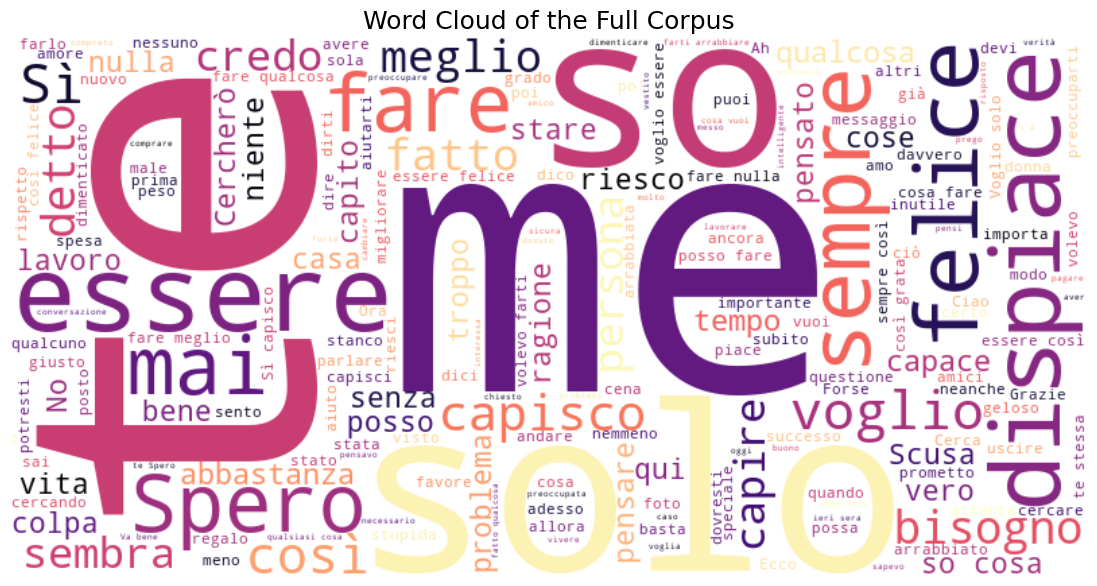


--- Summary Table: Top 20 Most Frequent Words (Unigrams) ---

        Word  Frequency
0     essere       1877
1         te       1844
2         me       1506
3       fare       1506
4       solo       1445
5         so       1297
6       così       1187
7       cosa       1060
8     sempre        898
9   dispiace        892
10    felice        888
11    voglio        880
12       mai        822
13        sì        752
14     nulla        656
15    troppo        621
16  qualcosa        590
17     spero        580
18     posso        545
19   capisco        534
--------------------------------------------------

--- Summary Table: Top 20 Most Frequent Bigrams ---

             Bigram  Frequency
0           so cosa        266
1       fare meglio        196
2     fare qualcosa        187
3       sempre così        146
4         cosa fare        143
5     voglio essere        142
6   cercherò essere        139
7        fare nulla        135
8       voglio solo        130
9        posso far

In [7]:
# SECTION 3: N-GRAM ANALYSIS

if not df_dataset.empty:
    # --- 3.1 Word Cloud ---
    italian_stopwords = list(stopwords.words('italian'))
    text_corpus = " ".join(str(text) for text in df_dataset[TEXT_COLUMN])

    wordcloud = WordCloud(stopwords=italian_stopwords, background_color="white", width=800, height=400, colormap='magma').generate(text_corpus)
    plt.figure(figsize=(14, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title('Word Cloud of the Full Corpus', fontsize=18)
    plt.show()

    # --- 3.2 N-Gram Analysis ---
    def get_top_ngrams_with_freq(corpus, n=1, top_k=20):
        corpus = corpus.str.lower().str.replace(f'[{re.escape(string.punctuation)}]', '', regex=True)
        all_tokens = [word for text in corpus for word in str(text).split() if word and word not in italian_stopwords]
        n_grams_list = list(ngrams(all_tokens, n))
        return [(" ".join(gram), freq) for gram, freq in Counter(n_grams_list).most_common(top_k)]

    # SUMMARY TABLE for Top Unigrams (from Word Cloud)
    print("\n--- Summary Table: Top 20 Most Frequent Words (Unigrams) ---\n")
    top_unigrams = get_top_ngrams_with_freq(df_dataset[TEXT_COLUMN], n=1)
    df_unigrams = pd.DataFrame(top_unigrams, columns=['Word', 'Frequency'])
    print(df_unigrams)
    print("-" * 50)

    # SUMMARY TABLE for Top Bigrams
    print("\n--- Summary Table: Top 20 Most Frequent Bigrams ---\n")
    top_bigrams = get_top_ngrams_with_freq(df_dataset[TEXT_COLUMN], n=2)
    df_bigrams = pd.DataFrame(top_bigrams, columns=['Bigram', 'Frequency'])
    print(df_bigrams)
    print("-" * 50)

C:\Users\Andrei\AppData\Local\Temp\ipykernel_26840\1111828535.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=df_dataset[PERSON_COUPLE_COLUMN], x=df_dataset['conversation_length'], palette='viridis')


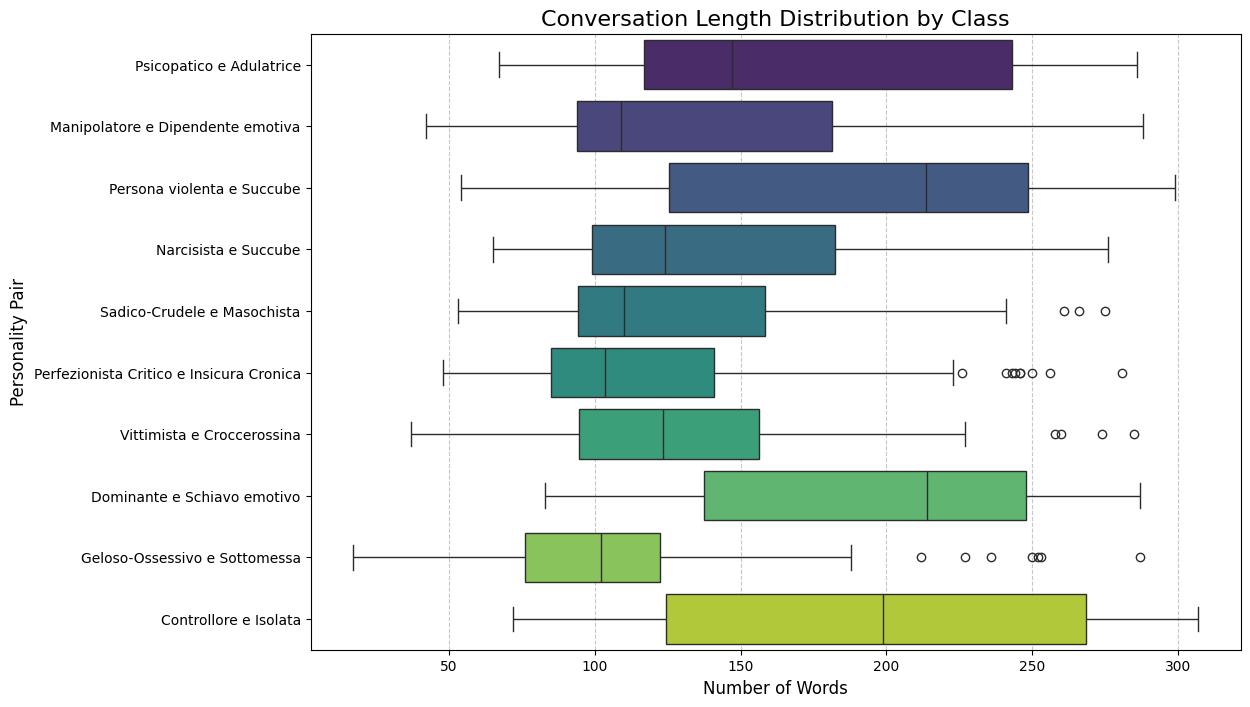

C:\Users\Andrei\AppData\Local\Temp\ipykernel_26840\1111828535.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=class_ttr.index, x=class_ttr.values, palette='plasma')



--- Summary Table: Conversation Length Statistics by Class ---

                                          count    mean        std   min  \
person_couple                                                              
Controllore e Isolata                     100.0  197.74  72.625457  72.0   
Dominante e Schiavo emotivo               100.0  197.56  58.866450  83.0   
Geloso-Ossessivo e Sottomessa             100.0  107.76  49.784408  17.0   
Manipolatore e Dipendente emotiva         100.0  137.14  60.815671  42.0   
Narcisista e Succube                      100.0  143.33  55.698332  65.0   
Perfezionista Critico e Insicura Cronica  100.0  121.74  54.351386  48.0   
Persona violenta e Succube                100.0  192.13  64.168285  54.0   
Psicopatico e Adulatrice                  100.0  171.86  62.938325  67.0   
Sadico-Crudele e Masochista               100.0  128.50  50.967112  53.0   
Vittimista e Croccerossina                100.0  127.83  52.398253  37.0   

                      

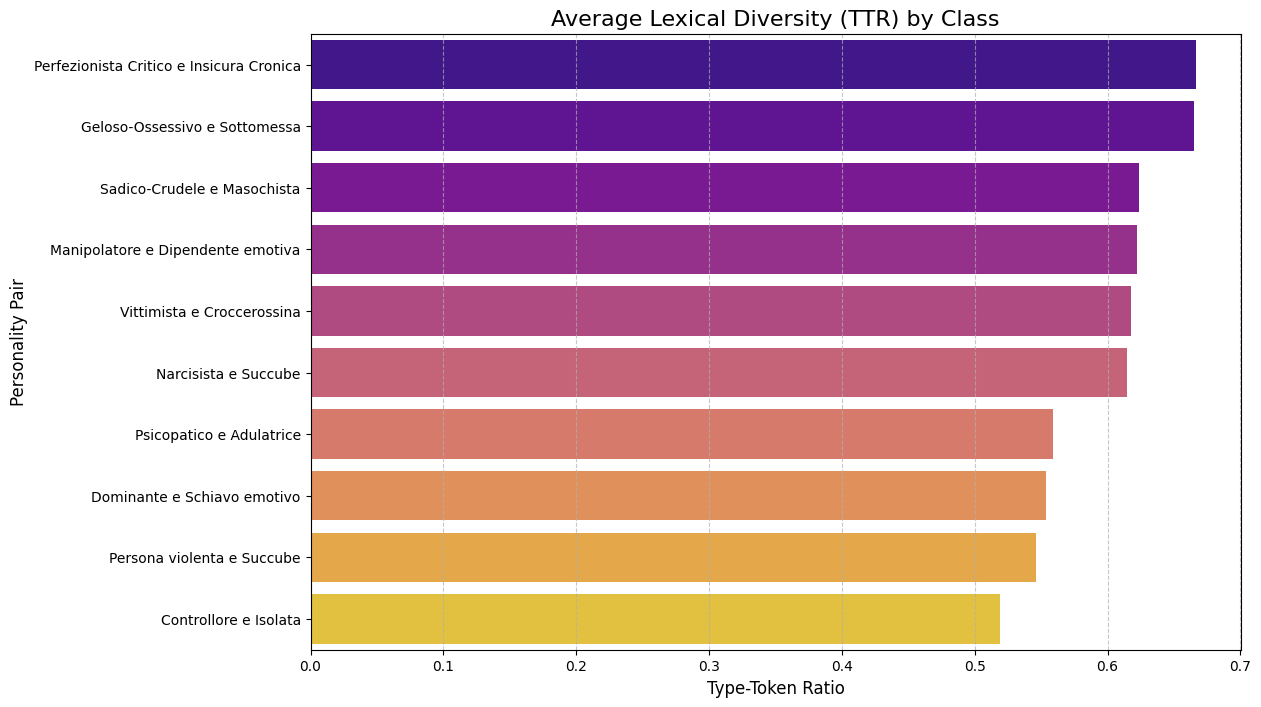


--- Summary Table: Average Lexical Diversity (TTR) by Class ---

                              person_couple  Average TTR
0  Perfezionista Critico e Insicura Cronica     0.666806
1             Geloso-Ossessivo e Sottomessa     0.664997
2               Sadico-Crudele e Masochista     0.623692
3         Manipolatore e Dipendente emotiva     0.621876
4                Vittimista e Croccerossina     0.617918
5                      Narcisista e Succube     0.614820
6                  Psicopatico e Adulatrice     0.558984
7               Dominante e Schiavo emotivo     0.553989
8                Persona violenta e Succube     0.546517
9                     Controllore e Isolata     0.518949
------------------------------------------------------------


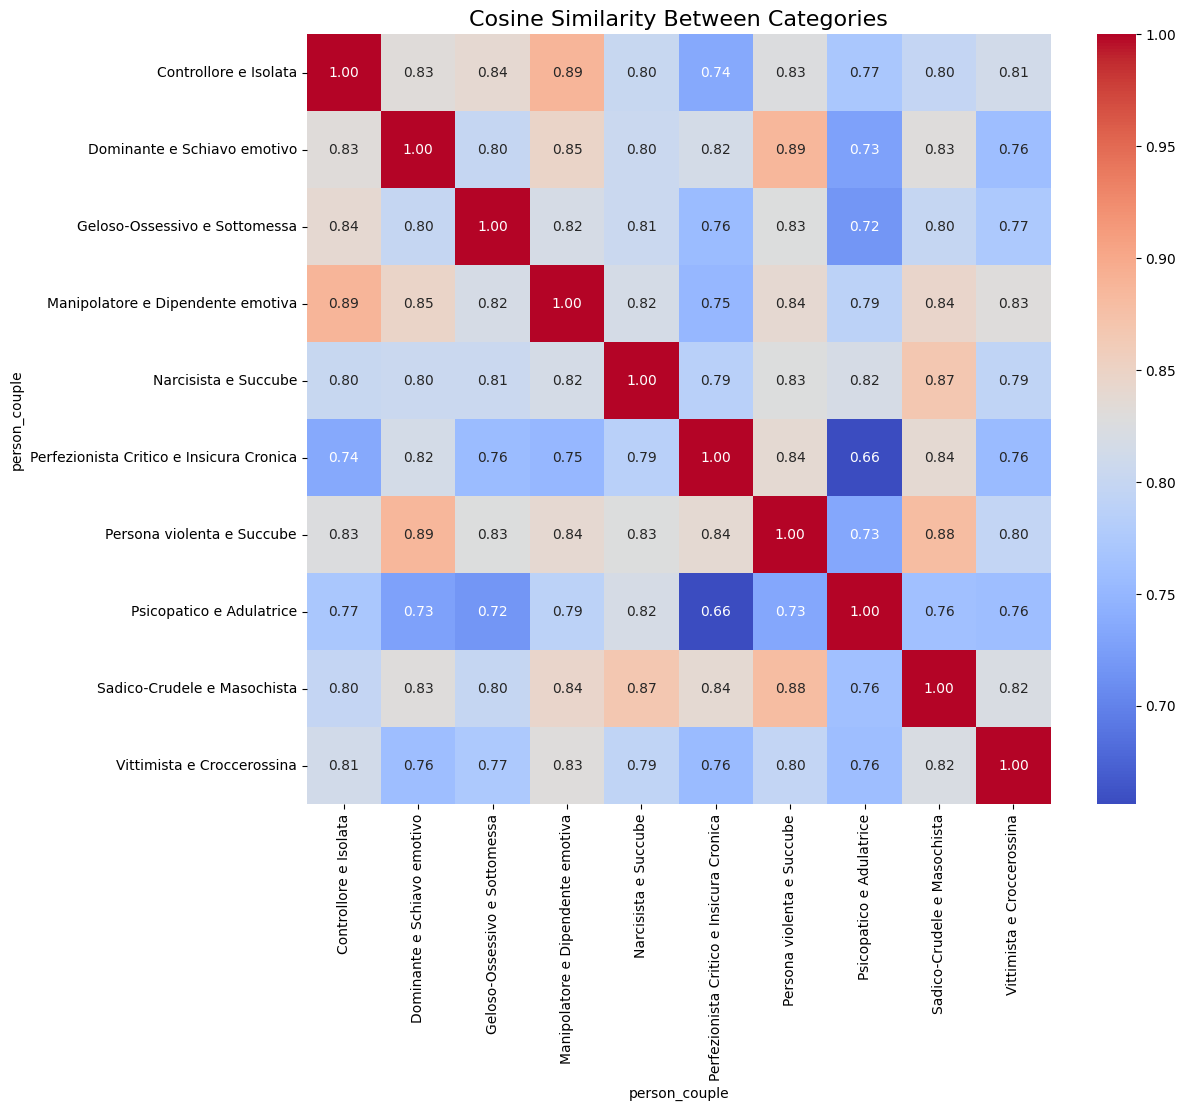


--- Summary Table: Cosine Similarity Matrix ---

person_couple                             Controllore e Isolata  \
person_couple                                                     
Controllore e Isolata                                  1.000000   
Dominante e Schiavo emotivo                            0.831094   
Geloso-Ossessivo e Sottomessa                          0.839592   
Manipolatore e Dipendente emotiva                      0.888150   
Narcisista e Succube                                   0.801555   
Perfezionista Critico e Insicura Cronica               0.736555   
Persona violenta e Succube                             0.826354   
Psicopatico e Adulatrice                               0.770359   
Sadico-Crudele e Masochista                            0.797245   
Vittimista e Croccerossina                             0.812052   

person_couple                             Dominante e Schiavo emotivo  \
person_couple                                                           

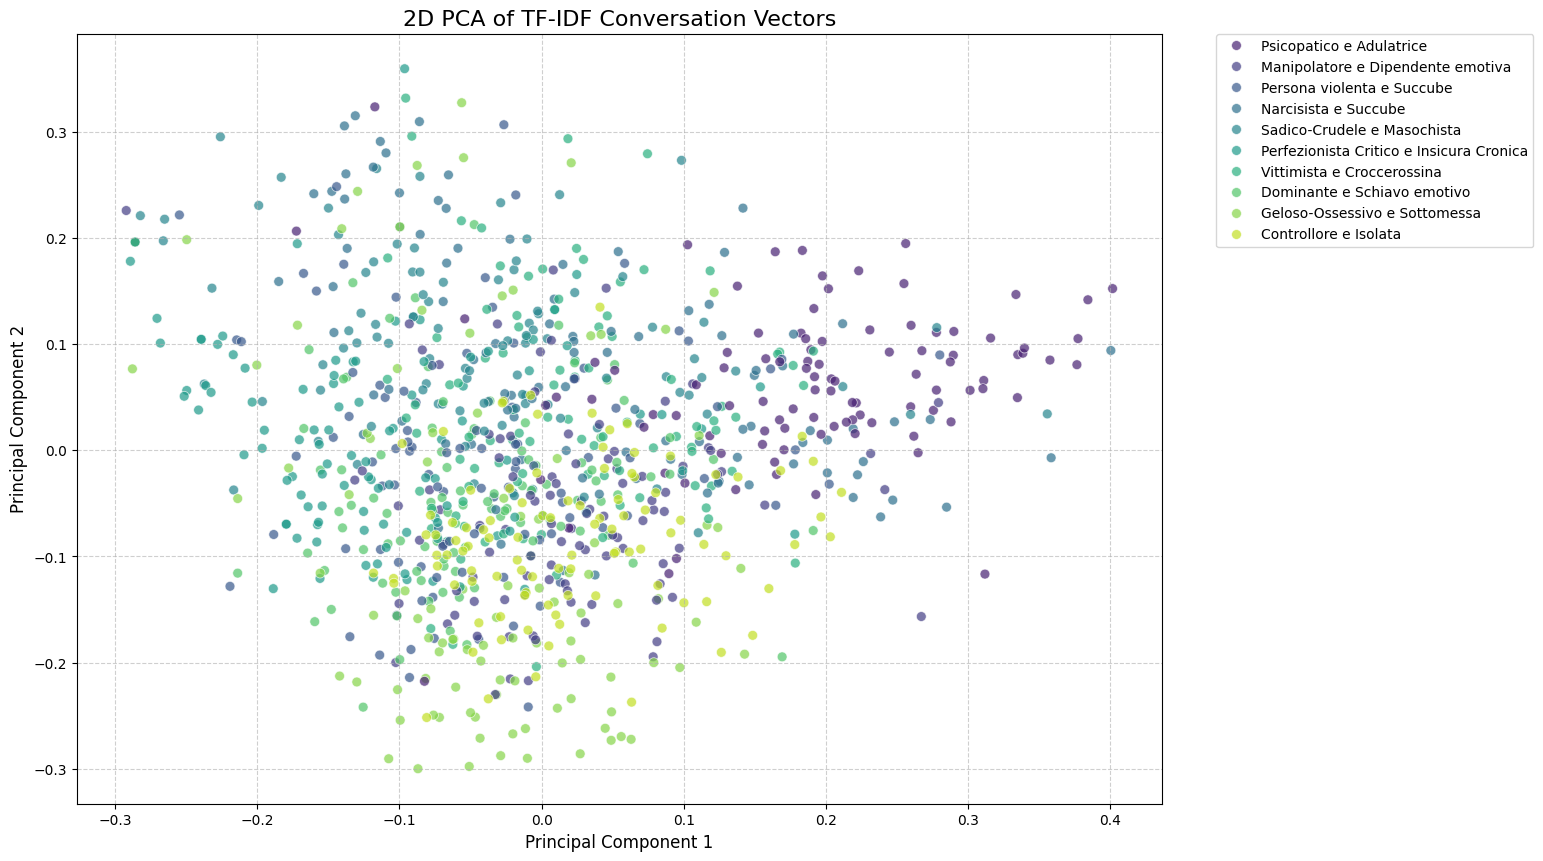


--- Summary: PCA Variance ---

variance by Principal Component 1: 1.65%
variance by Principal Component 2: 1.56%
Total variance by first 2 components: 3.21%
------------------------------------------------------------


In [9]:
# SECTION 4: VECTORIZATION AND SIMILARITY ANALYSIS

if not df_dataset.empty:
    # --- 4.1 Word Count Distribution by Class ---
    plt.figure(figsize=(12, 8))
    sns.boxplot(y=df_dataset[PERSON_COUPLE_COLUMN], x=df_dataset['conversation_length'], palette='viridis')
    plt.title('Conversation Length Distribution by Class', fontsize=16)
    plt.xlabel('Number of Words', fontsize=12)
    plt.ylabel('Personality Pair', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()
    
    # SUMMARY TABLE for Word Count by Class
    print("\n--- Summary Table: Conversation Length Statistics by Class ---\n")
    print(df_dataset.groupby(PERSON_COUPLE_COLUMN)['conversation_length'].describe())
    print("-" * 60)

    # --- 4.2 Lexical Diversity by Class (Type-Token Ratio) ---
    def calculate_ttr(text):
        if not isinstance(text, str) or len(text) == 0:
            return 0
        tokens = text.lower().split()
        if len(tokens) == 0:
            return 0
        return len(set(tokens)) / len(tokens)

    df_dataset['ttr'] = df_dataset[TEXT_COLUMN].apply(calculate_ttr)
    class_ttr = df_dataset.groupby(PERSON_COUPLE_COLUMN)['ttr'].mean().sort_values(ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(y=class_ttr.index, x=class_ttr.values, palette='plasma')
    plt.title('Average Lexical Diversity (TTR) by Class', fontsize=16)
    plt.xlabel('Type-Token Ratio', fontsize=12)
    plt.ylabel('Personality Pair', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

    # SUMMARY TABLE for TTR by Class
    print("\n--- Summary Table: Average Lexical Diversity (TTR) by Class ---\n")
    print(class_ttr.reset_index(name='Average TTR'))
    print("-" * 60)

    # --- 4.3 Vectorization & Similarity Analysis ---
    class_text_corpus = df_dataset.groupby(PERSON_COUPLE_COLUMN)[TEXT_COLUMN].apply(lambda x: ' '.join(x)).reset_index()
    
    tfidf_vectorizer = TfidfVectorizer(stop_words=italian_stopwords, max_features=1000)
    tfidf_matrix = tfidf_vectorizer.fit_transform(class_text_corpus[TEXT_COLUMN])
    cosine_sim_matrix = cosine_similarity(tfidf_matrix)
    
    # Create DataFrame for the heatmap table
    df_cosine_sim = pd.DataFrame(cosine_sim_matrix, 
                                 index=class_text_corpus[PERSON_COUPLE_COLUMN], 
                                 columns=class_text_corpus[PERSON_COUPLE_COLUMN])

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        df_cosine_sim, annot=True, fmt=".2f", cmap='coolwarm',
    )
    plt.title('Cosine Similarity Between Categories', fontsize=16)
    plt.show()
    
    # SUMMARY TABLE for Cosine Similarity
    print("\n--- Summary Table: Cosine Similarity Matrix ---\n")
    print(df_cosine_sim)
    print("-" * 60)

    # --- 4.4 PCA Visualization ---
    tfidf_matrix_full = tfidf_vectorizer.fit_transform(df_dataset[TEXT_COLUMN])
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    tfidf_pca = pca.fit_transform(tfidf_matrix_full.toarray())

    pca_df = pd.DataFrame(data=tfidf_pca, columns=['PCA1', 'PCA2'])
    pca_df['Category'] = df_dataset[PERSON_COUPLE_COLUMN]

    plt.figure(figsize=(14, 10))
    sns.scatterplot(
        x='PCA1', y='PCA2', hue='Category', palette='viridis',
        data=pca_df, alpha=0.7, s=50
    )
    plt.title('2D PCA of TF-IDF Conversation Vectors', fontsize=16)
    plt.xlabel('Principal Component 1', fontsize=12)
    plt.ylabel('Principal Component 2', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid(linestyle='--', alpha=0.6)
    plt.show()
    
    # SUMMARY for PCA
    print("\n--- Summary: PCA Variance ---\n")
    print(f"variance by Principal Component 1: {pca.explained_variance_ratio_[0]:.2%}")
    print(f"variance by Principal Component 2: {pca.explained_variance_ratio_[1]:.2%}")
    print(f"Total variance by first 2 components: {sum(pca.explained_variance_ratio_):.2%}")
    print("-" * 60)